# Address Scoring Model - Model Training - August 2022

In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import os
from glob import glob
import pickle as pk
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


today = datetime.strptime('2022-08-16', '%Y-%m-%d')
today

datetime.datetime(2022, 8, 16, 0, 0)

In [30]:
DATA_DATE = '2022-12-06'  # the date the data (AIMS, ODS, EDW, Humach, etc) was exported. 

# Corresponds to datalabs/analysis/address/scoring/data/{DATA_DATE}
assert os.path.exists(f'../../../../../datalabs/analysis/address/scoring/data/{DATA_DATE}')


In [11]:
TRAINING_FOLDER = '202208'  # /datalabs/analysis/address/scoring/training/{TRAINING_FOLDER}/

if not os.path.exists(TRAINING_FOLDER):
    os.mkdir(TRAINING_FOLDER)
    os.mkdir(f'{TRAINING_FOLDER}/features')

# Stage 1 - Prepare Humach sample+result data


To start, we need the following columns:

* me  - AMA's general physician ID
* entity_id  - physician ID from AIMS
* comm_id  - address ID from AIMS
* address_key  - combination of street address + 5 digit zip code
* state_cd  - not present in this snippet but I patched it in the data later. Required for license features.
* survey_date  - typically the sample generation date
* comments  - result field from Humach survey result file
* office_address_verified_updated  - flag value from Humach result file
* status  - 'CORRECT' or 'INCORRECT'  - determined by combination of 'comments' value and 'office_address_verified_updated'


Humach result data can be extracted from Derek's WSLIVE_RESULTS.sas7bdat file, located here:

- U:/Source Files/Data Analytics/Derek/SAS_DATA/SURVEY/wslive_results.sas7bdat

#### How to determine 'status':

If 'comments' value is in ['COMPLETE', 'RESPONDED TO SURVEY - AMA'] and 'office_address_verified_updated' value == 1, the phone call in the Humach surveying attempt was completed and did NOT result in the address being updated. If office_address_verified_updated == 2, it indicates the address that Humach gave back to us was updated/different than the address value we provided in the original survey sample.

The 'address_key' value in this data should be the SAMPLED address, not the RESULT address from Humach.

'status' is what we're trying to predict. INCORRECT = 0, CORRECT = 1



In [2]:
training_data = pd.read_csv('../data/2022-08-16/address_scoring_training_2022-08-16.txt', sep='|', dtype=str)

training_data

,me,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_id
0,00576081367,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,45742238
1,00512830081,7774210,4300 GOLDEN CENTER DR STE A_95667,2021-12-01,COMPLETE,1,CORRECT,1795894
2,70401940012,15135387,400 WESTAGE BUSINESS CTR DR STE 210_12524,2021-12-01,COMPLETE,1,CORRECT,13736433
3,02105961769,25976969,4429 CLARA ST STE 540_70115,2021-12-01,COMPLETE,1,CORRECT,4652332
4,56111960017,18826604,2330 MORSE RD STE A_43229,2021-12-01,COMPLETE,1,CORRECT,21579099
...,...,...,...,...,...,...,...,...
39886,03006920933,20976264,13015 W LINEBAUGH AVE_33626,2022-06-01,COMPLETE,1,CORRECT,6643802
39887,03840081094,811034,9500 EUCLID AVE_44195,2022-06-01,COMPLETE,2,INCORRECT,28375733
39888,03845830095,22418302,3535 SOUTHERN BLVD DEPT OF_45429,2022-06-01,COMPLETE,2,INCORRECT,8704120
39889,30803781342,7599181,66 CALLE SANTA CRUZ STE 310_00961,2022-06-01,COMPLETE,1,CORRECT,12302117


In [3]:
training_data['comments'].value_counts()

COMPLETE                     39811
MOVED, NO FORWARDING INFO       62
RESPONDED TO SURVEY - AMA       17
NOT IN SERVICE                   1
Name: comments, dtype: int64

In [4]:
training_data['survey_date'].value_counts()

2021-12-01    8779
2022-02-01    7565
2022-05-01    7361
2022-04-01    7034
2022-03-01    5195
2022-06-01    2114
2022-01-01    1843
Name: survey_date, dtype: int64

In [6]:

#if 'state_cd' not in training_data.columns.values:
#    addr = pd.read_csv('../data/2022-08-16/POST_ADDR_AT_PROCESSED.txt', sep='|', dtype=str)
#    training_data = training_data.drop_duplicates().merge(addr[['comm_id', 'state_cd']].drop_duplicates(), on='comm_id')
#training_data



# Stage 2 - Grouping training data to send through feature engineering pipeline


The feature engineering process is pretty wild and it gets really hairy if you try to handle the same data from different time perspectives in the same dataframe.

Imagine, Doctor A has Address X which gets surveyed in January.

Six months later, the same address for the same doctor goes through the survey again.

The data influencing the features for that address in January is going to be different in July; other physicians may also be assigned the same address within the intermediary time period, maybe Doctor A gets a new license in another state or their active license has expired.

To keep things simple and not have to deal too much with time-relevancy, we just treat each sample as its own mini-dataset and push them through the feature engineering individually, combining them to form an aggregated dataset to use in this notebook.



In [5]:
groups = training_data.groupby('survey_date')

In [21]:
DATES_TO_RUN = []

In [22]:
for name, group in groups:
    savepath = f"{TRAINING_FOLDER}/{name}.txt"
    if not os.path.exists(savepath.split('/')[0]):
        os.makedirs(savepath.split('/')[0])
    group.to_csv(savepath, sep='|', index=False)
    
    DATES_TO_RUN.append(name)

In [23]:
DATES_TO_RUN  # copy these

['2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01']

In [8]:
# not sure this is being used anywhere...

#humach = pd.read_csv('202208/humach_sample_res_match_total_with_comm.txt', sep='|', dtype=str)
#humach

,me,comm_id,sample_id,row_id,address_key,survey_date,comments,office_address_verified_updated
0,05605850423,NaN,1,1,240 MAPLE ST_54568,2020-09-01,NaN,NaN
1,04112952956,NaN,1,2,300 GRANITE RUN DR STE 160_17601,2020-09-01,NaN,NaN
2,02604110541,NaN,1,3,1025 MARSH ST_56001,2020-09-01,COMPLETE,1
3,04114980817,NaN,1,4,1200 S CEDAR CREST BLVD_18103,2020-09-01,COMPLETE,1
4,04816060635,NaN,1,5,150 GENTILLY BLVD_30120,2020-09-01,COMPLETE,1
...,...,...,...,...,...,...,...,...
407338,95704850019,NaN,NaN,NaN,1880 E Ridge Rd _14622,2022-01-01,REFUSAL,1
407339,95704850019,NaN,NaN,NaN,1880 E Ridge Rd _14622,2022-01-01,2ND ATTEMPT,1
407340,95705800040,NaN,NaN,NaN,331 E Main St _29730,2022-01-01,NOT IN SERVICE,1
407341,95708880061,NaN,NaN,NaN,110 E Medical Ln _29169,2022-01-01,"MOVED, NO FORWARDING INFO",1


In [12]:
#training_data['address_correct'] = (training_data['status'] == 'CORRECT').astype(int)
#training_data['address_correct'].value_counts()

1    30695
0     9196
Name: address_correct, dtype: int64

# Stage 3 - Feature engineering on each group data file

In [31]:
DATA_DATE

'2022-12-06'

In [32]:
TRAINING_FOLDER

'202208'

In [33]:
DATES_TO_RUN

['2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01']

### run datalabs/analysis/address/scoring/local__training__features.py with DATA_DATE, TRAINING_FOLDER, and DATES_TO_RUN as defined here



# Stage 4 - Concatenation of aggregated features

In [34]:
files = glob('202208/features/aggregate_out*')
files

['202208/features\\aggregate_out__2021-12-01.txt',
 '202208/features\\aggregate_out__2022-01-01.txt',
 '202208/features\\aggregate_out__2022-02-01.txt',
 '202208/features\\aggregate_out__2022-03-01.txt',
 '202208/features\\aggregate_out__2022-04-01.txt',
 '202208/features\\aggregate_out__2022-05-01.txt',
 '202208/features\\aggregate_out__2022-06-01.txt']

In [35]:
datalist = []
for file in files:
    df = pd.read_csv(file, sep='|', dtype=str)
    datalist.append(df)
tdf = pd.concat(datalist, ignore_index=True)
tdf

,me,entity_id,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_unknown,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_licensure,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_webphyc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_acsimb-mmx,entity_comm_src_cat_code_polo-model,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_do-portal,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_websrch,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_status_unknown,humach_address_status_correct,humach_address_status_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_nat-down,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_join-renew,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_polo-ppd,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_cred-addr,entity_comm_src_cat_code_webprr
0,00576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,4.8273972602739725,7,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Stage 5 - Open-ended - train, evaluate, and save a model

In [36]:
tdf.columns.values

array(['me', 'entity_id', 'comm_id', 'address_key', 'survey_date',
       'comments', 'office_address_verified_updated', 'status',
       'entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_unknown',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_licensure',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfso

In [37]:
tdf['humach_never_surveyed'].value_counts()  # future update - random dropout of humach features

0    365
Name: humach_never_surveyed, dtype: int64

In [19]:
fillmax = ['entity_comm_address_age', 'humach_years_since_survey']
fillneg1 = ['license_this_state_years_since_expiration', 'years_licensed_in_this_state']

for col in fillmax:
    mx = tdf[col].dropna().max()
    tdf[col].fillna(mx, inplace=True)
for col in fillneg1:
    tdf[col].fillna(-1, inplace=True)


In [38]:
info_cols = [
    'me', 'entity_id', 'comm_id', 'address_key', 'state_cd',
    'survey_date', 'comments', 'office_address_verified_updated',
    'status'
]
for col in tdf.columns.values:
    if col not in info_cols:
        tdf[col].fillna(0, inplace=True)
tdf

,me,entity_id,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_unknown,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_licensure,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_webphyc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_acsimb-mmx,entity_comm_src_cat_code_polo-model,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_do-portal,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_websrch,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_status_unknown,humach_address_status_correct,humach_address_status_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_nat-down,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_join-renew,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_polo-ppd,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_cred-addr,entity_comm_src_cat_code_webprr
0,00576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,4.8273972602739725,7,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
tdf.columns.values

array(['me', 'entity_id', 'comm_id', 'address_key', 'state_cd',
       'survey_date', 'comments', 'office_address_verified_updated',
       'status', 'entity_comm_address_age',
       'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfsol', 'entity_comm_src_cat_code_ncoa',
       'entity_comm_src_cat_code

In [22]:
to_scale = []
for col in tdf.columns.values:
    if 'count' in col or 'frequency' in col or '_age' in col or 'years' in col:
        print(col)
        to_scale.append(col)

entity_comm_address_age
entity_comm_address_active_frequency
entity_comm_usg_comm_id_comm_usage_counts_active_po
entity_comm_usg_comm_id_comm_usage_counts_active_pp
entity_comm_usg_comm_id_comm_usage_counts_active_web
entity_comm_usg_comm_id_comm_usage_counts_active_op
entity_comm_usg_comm_id_comm_usage_counts_active_amc
entity_comm_usg_comm_id_comm_usage_counts_active_bill
entity_comm_usg_comm_id_comm_usage_counts_active_amnw
entity_comm_usg_comm_id_comm_usage_counts_active_arch
entity_comm_usg_comm_id_comm_usage_counts_active_jama
entity_comm_usg_comm_id_comm_usage_counts_active_mshp
entity_comm_usg_comm_id_comm_usage_counts_active_mbr
entity_comm_usg_comm_id_comm_usage_counts_history_po
entity_comm_usg_comm_id_comm_usage_counts_history_pp
entity_comm_usg_comm_id_comm_usage_counts_history_web
entity_comm_usg_comm_id_comm_usage_counts_history_op
entity_comm_usg_comm_id_comm_usage_counts_history_amc
entity_comm_usg_comm_id_comm_usage_counts_history_jama
entity_comm_usg_comm_id_comm_usa

In [23]:
tdf['has_active_license_in_this_state'].value_counts()

1    38255
0     1770
Name: has_active_license_in_this_state, dtype: int64

In [24]:
for col in to_scale:
    scaler = MinMaxScaler()
    tdf[col] = scaler.fit_transform(tdf[col].values.reshape(-1, 1))

In [25]:
tdf['entity_comm_address_active_frequency'].min(), tdf['entity_comm_address_active_frequency'].max()

(0.0, 1.0)

In [26]:
tdf['entity_comm_address_active_frequency'].min(), tdf['entity_comm_address_active_frequency'].max()

(0.0, 1.0)

In [27]:
tdf['triangulation_iqvia_agreement'] = (tdf['triangulation_iqvia_agreement'].astype(str) == 'True').astype(int)
tdf['triangulation_iqvia_other'] = (tdf['triangulation_iqvia_other'].astype(str) == 'True').astype(int)
tdf['triangulation_symphony_agreement'] = (tdf['triangulation_symphony_agreement'].astype(str) == 'True').astype(int)
tdf['triangulation_symphony_other'] = (tdf['triangulation_symphony_other'].astype(str) == 'True').astype(int)

tdf.head()

,me,entity_id,comm_id,address_key,state_cd,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_address_result_unknown,humach_address_result_correct,humach_address_result_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_stu-matric
0,576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,CA,2021-12-01,COMPLETE,1,CORRECT,0.038855,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00000,0.001053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000667,0.000000,0.000851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.076056,0.065991,0.5,1.0,0.0,0.0,0,1,0,1,0,0,0,0,0
1,512830081,1795894,7774210,4300 GOLDEN CENTER DR STE A_95667,CA,2021-12-01,COMPLETE,1,CORRECT,0.122917,3.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [28]:
train = tdf.drop(columns=info_cols, axis=1)

train

,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_address_result_unknown,humach_address_result_correct,humach_address_result_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_stu-matric
0,0.038855,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00000,0.001053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000667,0.000000,0.000851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.076056,0.065991,0.500,1.0,0.0,0.0,0,1,0,1,0,0,0,0,0
1,0.122917,3.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00049,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002001,0.000461,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.296657,0.000000,1.000,0,0,0,0,1,0,1,0,0,0,0,0
2,0.027245,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [29]:
labels = (tdf['status'] == 'CORRECT').astype(int)
labels[:3]

0    1
1    1
2    1
Name: status, dtype: int32

In [32]:
train['years_licensed_in_this_state']

0        0.076056
1        0.296657
2        0.187939
3        0.196433
4        0.135511
           ...   
40020    0.125705
40021    0.210486
40022    0.300517
40023    0.000000
40024    0.237202
Name: years_licensed_in_this_state, Length: 40025, dtype: float64

In [34]:
train['triangulation_iqvia_agreement'].value_counts()

0    24829
1    15196
Name: triangulation_iqvia_agreement, dtype: int64

In [37]:
train['triangulation_symphony_agreement'].value_counts()

0    25959
1    14066
Name: triangulation_symphony_agreement, dtype: int64

In [38]:
train['triangulation_iqvia_agreement'].value_counts()

0    24829
1    15196
Name: triangulation_iqvia_agreement, dtype: int64

In [39]:
for col in train.columns:
    if train[col].apply(lambda x: isinstance(x, str)).any():
        print(col)
        break

entity_comm_active_addresses


In [40]:
train['entity_comm_active_addresses'].value_counts()

1.0    20817
2.0    14384
3.0     3634
0        926
4.0      254
5.0       10
Name: entity_comm_active_addresses, dtype: int64

In [41]:
for col in train.columns:
    if train[col].apply(lambda x: isinstance(x, str)).any():
        train[col] = train[col].astype(float)

In [42]:
train['entity_comm_active_addresses']

0        1.0
1        3.0
2        1.0
3        2.0
4        2.0
        ... 
40020    1.0
40021    1.0
40022    1.0
40023    1.0
40024    2.0
Name: entity_comm_active_addresses, Length: 40025, dtype: float64

In [43]:
train['entity_comm_address_age'] = train['entity_comm_address_age'].astype(float)
train['entity_comm_active_addresses'] = train['entity_comm_active_addresses'].astype(float)

# Survey-related feature dropout

Most addresses we're looking at predicting quality for have never been through Humach surveys, yet we don't exactly have good verification data on non-surveyed addresses, obviously, so simulate the data by artificially 'blinding' those related features for a ssubset of training data.

In [44]:
train['humach_never_surveyed'] = 0

n = train.shape[0] / 5
n = round(n)
n

8005

In [45]:
for col in train.columns:
    if 'humach' in col:
        print(col)

humach_years_since_survey
humach_address_result_unknown
humach_address_result_correct
humach_address_result_incorrect
humach_never_surveyed


In [46]:
pseudo_humach_dropout = train.sample(n).index

In [47]:
train.loc[
    pseudo_humach_dropout, 
    ['humach_address_result_unknown', 'humach_address_result_correct', 'humach_address_result_incorrect']
] = 0
train.loc[
    pseudo_humach_dropout, 
    ['humach_never_surveyed', 'humach_years_since_survey']
] = 1

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, stratify=labels, random_state=18)


In [52]:

def evaluate_model_predictions(y_pred, y_labels):
    y_pred_classes = [1 if p>=.5 else 0 for p in y_pred]
    
    accuracy = accuracy_score(y_pred=y_pred_classes, y_true=y_labels)
    precision = precision_score(y_pred=y_pred_classes, y_true=y_labels)
    recall = recall_score(y_pred=y_pred_classes, y_true=y_labels)
    roc_auc = roc_auc_score(y_score=y_pred, y_true=y_labels)
    
    print(f'Accuracy:\t{round(accuracy, 4)}')
    print(f'Precision:\t{round(precision, 4)}')
    print(f'Recall:\t\t{round(recall, 4)}')
    print(f'ROC_AUC:\t{round(roc_auc, 4)}')
    
    return accuracy, precision, recall, roc_auc

In [64]:
#evaluate_model_predictions([p[1] for p in cv_lgb.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.8004
Precision:	0.8095
Recall:		0.9685
ROC_AUC:	0.7631


(0.8003747657713929,
 0.8095496473141617,
 0.9685167153521584,
 0.7630970048516428)

In [60]:
#evaluate_model_predictions([p[1] for p in cv_lgb.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.8025
Precision:	0.8122
Recall:		0.9671
ROC_AUC:	0.7666


(0.8024984384759525,
 0.8121848166825678,
 0.9670561506004544,
 0.7665556207748012)

In [62]:
#from lightgbm import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

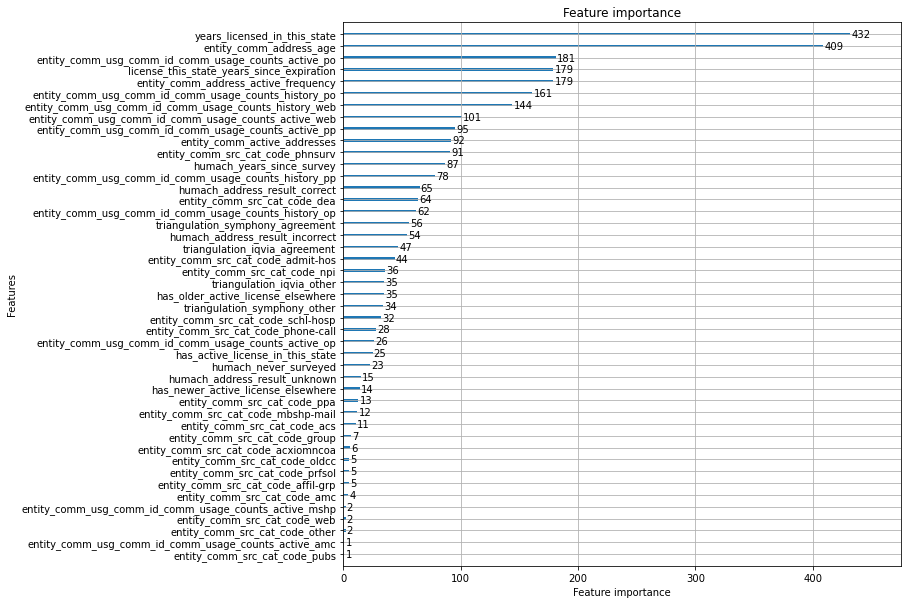

In [63]:
# plot_importance(cv_lgb.best_estimator_, figsize=(10, 10))

In [64]:
# train a new model on all training data with the best model's params

In [65]:
#cv_lgb.best_params_

{'pos_bagging_fraction': 1.0,
 'num_leaves': 31,
 'neg_bagging_fraction': 0.8,
 'min_child_weight': 0.001,
 'metric': 'auc',
 'learning_rate': 0.07,
 'feature_fraction': 0.6,
 'bagging_fraction': 1}

In [66]:
#model = LGBMClassifier(**cv_lgb.best_params_)

In [67]:
#model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


LGBMClassifier(bagging_fraction=1, feature_fraction=0.6, learning_rate=0.07,
               metric='auc', neg_bagging_fraction=0.8,
               pos_bagging_fraction=1.0)

<AxesSubplot:>

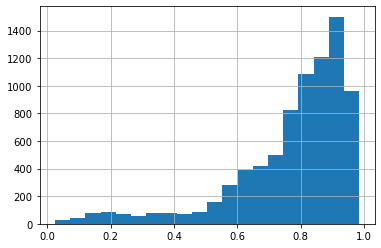

In [68]:
y_pred = [p[1] for p in model.predict_proba(X_test)]

pd.Series(y_pred).hist(bins=20)

In [69]:
#evaluate_model_predictions([p[1] for p in model.predict_proba(X_test)], y_test)

Accuracy:	0.8025
Precision:	0.8122
Recall:		0.9671
ROC_AUC:	0.7666


(0.8024984384759525,
 0.8121848166825678,
 0.9670561506004544,
 0.7665556207748012)

In [71]:
# model.fit(train, labels)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMClassifier(bagging_fraction=0.5, feature_fraction=1.0, learning_rate=0.07,
               metric='auc', min_child_weight=1, neg_bagging_fraction=0.8,
               num_leaves=15, pos_bagging_fraction=0.5)

In [71]:
str(today.date())

'2022-08-16'

In [53]:
today = '2022-11-06'

In [54]:
def save_model(mdl, save_name=f'model_{str(today)}.pkl'):
    pk.dump(mdl, open(save_name, 'wb'))


In [55]:
#save_model(model)

### Another model - RandomForest

In [77]:
"""
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 12],
    "min_samples_leaf" : [18, 19, 20],
    "min_samples_split" : [8, 9, 10]
}


RFC_Model = RandomForestClassifier()
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Score : ', RFC_grid.best_score_)"""

Best Parameters :  {'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 9, 'n_estimators': 25}

Best Score :  0.8017176764522173


<AxesSubplot:>

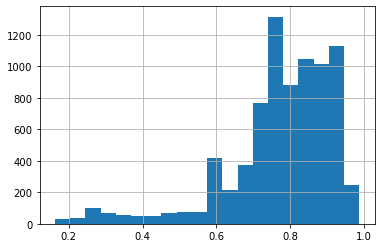

In [79]:
#y_pred = [p[1] for p in RFC_grid.best_estimator_.predict_proba(X_test)]

#pd.Series(y_pred).hist(bins=20)

In [87]:
#std = np.std([RFC_grid.best_estimator_.feature_importances_ for tree in RFC_grid.best_estimator_.estimators_], axis=0)

In [95]:
#std

array([2.77555756e-17, 1.73472348e-18, 6.93889390e-18, 1.30104261e-18,
       0.00000000e+00, 6.50521303e-19, 0.00000000e+00, 0.00000000e+00,
       8.67361738e-19, 0.00000000e+00, 1.35525272e-20, 0.00000000e+00,
       8.13151629e-20, 0.00000000e+00, 5.20417043e-18, 3.38813179e-21,
       0.00000000e+00, 8.13151629e-20, 0.00000000e+00, 0.00000000e+00,
       1.08420217e-19, 0.00000000e+00, 6.50521303e-19, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.73472348e-18, 1.35525272e-20,
       0.00000000e+00, 6.93889390e-18, 0.00000000e+00, 8.47032947e-22,
       0.00000000e+00, 6.77626358e-21, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.93889390e-18,
       6.93889390e-18, 0.00000000e+00, 0.00000000e+00, 6.77626358e-21,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.77626358e-21,
       0.00000000e+00, 0.00000000e+00, 2.08166817e-17, 6.93889390e-18,
      

In [104]:
#forest_importances.to_csv('rf_importances.csv')

C:\Users\Garrett\AppData\Local\Temp/ipykernel_61588/1518033307.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


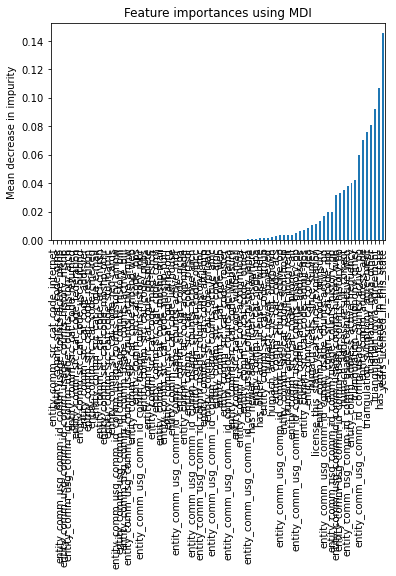

In [97]:
"""imp = RFC_grid.best_estimator_.feature_importances_

forest_importances = pd.Series(imp, index=X_test.columns).sort_values()

#forest_importances = forest_importances.tail(20)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()"""

In [56]:
X_train.columns.values

array(['entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfsol', 'entity_comm_src_cat_code_ncoa',
       'entity_comm_src_cat_code_other',
       'entity_comm_src_cat_code_admit-hos',
       'entity_comm_src_cat_code_group', 'entity_comm_src_cat_code_pps',
       'entity_comm_src

In [106]:
#evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.796
Precision:	0.8009
Recall:		0.9781
ROC_AUC:	0.7573


(0.7960024984384759,
 0.8009302325581396,
 0.9780915287244402,
 0.7572667653232499)

In [62]:
#evaluate_model_predictions([p[1] for p in RFC_grid.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.7951
Precision:	0.8002
Recall:		0.9781
ROC_AUC:	0.7533


(0.7951280449718926, 0.800185873605948, 0.9780915287244402, 0.7532584233649502)

In [130]:
#rf = RFC_grid.best_estimator_

### Another model - XGBoost

In [57]:

param_grid = {'n_estimators': [10, 25, 48, 75, 96, 151],
              'learning_rate': [0.2, 0.15, 0.1, 0.05],
              'eval_metric': ['mlogloss']}


grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
best_params = grid.best_params_
print('Best score of cross validation: {:.2f}'.format(grid.best_score_))
print('Best parameters:', best_params)


xgb = XGBClassifier()
xgb.set_params(**best_params)
xgb.fit(X_train, y_train)

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

Best score of cross validation: 0.81
Best parameters: {'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'n_estimators': 75}
Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [59]:
import xgboost

In [60]:
xgboost.__version__

'1.5.2'

In [66]:
xgb_savefile = f'model_xgb_{str(today)[:10]}.pkl'
xgb_savefile


'model_xgb_2022-11-06.pkl'

In [61]:
with open(f'model_xgb_{str(today)[:10]}.pkl', 'wb') as f:
    pk.dump(xgb, f)

In [67]:
xgb = pk.load(open('model_xgb_2022-11-06.pkl', 'rb'))

<AxesSubplot:>

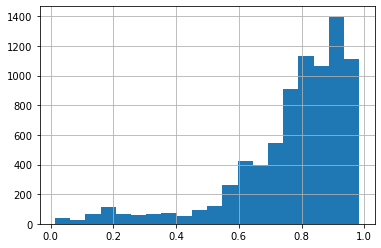

In [68]:
y_pred = [p[1] for p in xgb.predict_proba(X_test)]

pd.Series(y_pred).hist(bins=20)

In [69]:

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [70]:
xgb_importances = xgb.get_booster().get_score(importance_type='total_gain')
xgb_importances

{'entity_comm_address_age': 4461.75732421875,
 'entity_comm_active_addresses': 494.8714294433594,
 'entity_comm_address_active_frequency': 1554.37646484375,
 'entity_comm_src_cat_code_phone-call': 147.3911895751953,
 'entity_comm_src_cat_code_amc': 7.2661848068237305,
 'entity_comm_src_cat_code_ppa': 26.45979118347168,
 'entity_comm_src_cat_code_mfload': 0.5025043487548828,
 'entity_comm_src_cat_code_mbshp-mail': 15.967294692993164,
 'entity_comm_src_cat_code_acs': 34.8651237487793,
 'entity_comm_src_cat_code_roster': 1.4742794036865234,
 'entity_comm_src_cat_code_white-mail': 1.6542892456054688,
 'entity_comm_src_cat_code_list-house': 0.4981689453125,
 'entity_comm_src_cat_code_dea': 215.3610382080078,
 'entity_comm_src_cat_code_affil-grp': 11.588369369506836,
 'entity_comm_src_cat_code_acxiomncoa': 17.66832733154297,
 'entity_comm_src_cat_code_prfsol': 11.997206687927246,
 'entity_comm_src_cat_code_admit-hos': 634.7872314453125,
 'entity_comm_src_cat_code_group': 9.915702819824219,
 

In [71]:
xgb_imp = pd.Series(xgb_importances)

In [72]:
xgb_imp.to_csv('xgb_imp.csv')

In [73]:
xgb_imp = xgb_imp.sort_values()

<BarContainer object of 45 artists>

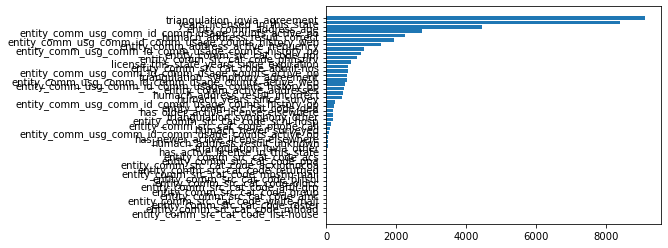

In [74]:
plt.barh(xgb_imp.index, xgb_imp)

In [75]:

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [139]:
train['humach_address_result_correct'].sum()

4230.0

# Expand testing, evaluation, etc.. Have fun!